In [104]:
# %matplotlib inline

# # import matplotlib.pyplot as plt
# from matplotlib.pylab import rcParams
# rcParams['figure.figsize'] = 12, 4


# import pandas as pd
# import numpy as np
# import xgboost as xgb
# from xgboost.sklearn import XGBClassifier

# from sklearn.preprocessing import LabelEncoder
# from sklearn.model_selection import train_test_split
# from sklearn.grid_search import GridSearchCV  
from sklearn.metrics import accuracy_score



# from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.text import one_hot
# from keras.preprocessing.sequence import pad_sequences

# from keras.models import Sequential
# from keras.models import load_model
# from keras.layers import Dense
# from keras.layers import Flatten
# from keras.layers import Embedding
# from keras.layers import LSTM
# from keras.layers import Dropout

# import pickle as pkl

# import h5py

## XGBoost with extended features

Previously, I trained an extremely boosted trees model for the Quora data problem. After parameter tuning using cross validation, I achieved a model with 78.4 test prediction accuracy. 

I also fit a set of deep neural networks on the `TREC` dataset, for the auxilliary purpose of question classification. As the data was too small to properly split the training data into a training and developement sets, I can't tell which of these models is most effective. 

In this notebook, I will train a series of XGBoost models again, with the same hyperparameters as my previous XGBoost model, but this time I will include the predictions of my question classication networks as features. To determine which network to use to create these predictions, I will use a 3-fold cross validation scheme. 

When I have picked the network I'd like to use, I will train the model using the corresponding predictions, and see if my test set accuracy increases. If so, then that will show that the information encoded in the question classification predictions is meaningful for this problem. 

### 0. Load the quora data

I've already done a lot of feature extractions. I'll use all the same features as in my previous XGBoost model, plus the extra linguistic features we are testing. 

In [4]:
data = pd.read_csv("../data/features.csv")

In [5]:
data.head()

,Unnamed: 0,id,qid1,qid2,question1,question2,is_duplicate,len_intersection,len_intersection_sw,num_words_q1,...,cosine_distance_sentence_embeddings,cityblock_distance_sentence_embeddings,jaccard_distance_sentence_embeddings,braycurtis_distance_sentence_embeddings,q1_highest_tfidf_weight,q2_highest_tfidf_weight,q1_max_tf_idf_embedding,q2_max_tf_idf_embedding,euclidean_distance_max_tfidf_word,cosine_distance_max_tfidf_word
0,1,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,10,5,14,...,0.004921,3.938651,1.0,0.049871,guide,guide,[-0.028461 -0.34314999 0.23021001 -0.063865...,[-0.028461 -0.34314999 0.23021001 -0.063865...,0.000000,3.250036e-08
1,2,1,3,4,What is the story of Kohinoor Koh - i - Noor D...,What would happen if the Indian government sto...,0,2,0,10,...,0.027946,10.689272,1.0,0.129334,noor,noor,[ 3.72870006e-02 -3.17849994e-01 -2.3973000...,[ 3.72870006e-02 -3.17849994e-01 -2.3973000...,0.000000,4.103800e-08
2,3,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,3,2,14,...,0.010569,5.988954,1.0,0.075329,vpn,dns,[-0.14387 0.66254002 -0.23895 0.036253...,[ -4.19200003e-01 5.06489992e-01 -3.4162998...,5.495713,4.284846e-01
3,4,3,7,8,Why am I mentally very lonely ? How can I solv...,Find the remainder when math 23 24 math is div...,0,0,0,11,...,0.065936,15.007527,1.0,0.184240,mentally,remainder,[ -1.92690000e-01 -3.28700006e-01 -4.2276001...,[-0.39732999 -0.13798 0.21100999 0.237990...,4.781672,8.190252e-01
4,5,4,9,10,"Which one dissolve in water quickly sugar , sa...",Which fish would survive in salt water ?,0,3,2,13,...,0.038453,11.145288,1.0,0.142762,di,salt,[ -1.13650002e-01 -3.47779989e-02 8.1817999...,[-0.064408 -0.073121 -0.25946999 0.15424 ...,6.219034,8.441631e-01


#####  0.1: HACKY FIX!!!

I found an issue in one of my features, `cosine_distance_max_tfidf_word`, a while ago. This feature is the cosine distance of the word embeddings of the words of highest TF-Idf weight in each sentence. 

If either of these words is not in the embedding model, then Is ent it to the origin. The cosine distance between any vector and zero is `NA` (division by the norm of zero). 

I fixed this issue in the notebook `features.ipynb`, where it should be fixed. I just never re-wrote the csv file, since tis takes a long time. 

I really should go back and re-write this file. But for now, I'll just re-fix these features. 

In [6]:
# quick fix - fixed on the features notebook but did not re-save data yet

fill = data[pd.isnull(data['cosine_distance_max_tfidf_word'])].apply(lambda x: 0 if
                        np.array_equal(x['q1_max_tf_idf_embedding'], x['q2_max_tf_idf_embedding'])  
                        else 1, axis = 1)

data['cosine_distance_max_tfidf_word'] = data['cosine_distance_max_tfidf_word'].fillna(fill)

In [7]:
fill = data[pd.isnull(data['cosine_distance_sentence_embeddings'])].apply(lambda x: 0 if
                        np.array_equal(x['q1_embedding'], x['q2_embedding'])  
                        else 1, axis = 1)

if len(fill) > 0:
    data['cosine_distance_sentence_embeddings'] = data['cosine_distance_sentence_embeddings'].fillna(fill)

#### 0.2 Loading the sentence Tokenizer

This will allow me to encode the quesions into index vectors in a way which is consistent with the the vectors with which the deep learning models were trained. 



In [13]:
# load pickled word tokenzier
with open("../models/tokenizer.pickle", "rb") as handle:
    tokenizer = pkl.load(handle)

#### 0.3 Load the label encoder

This will be used to convert question labels to one-hot encoding and back. 

In [16]:
with open("../models/trec_label_encoder.pickle", "rb") as handle:
    label_encoder = pkl.load(handle)

#### 0.4 Setting aside a sample

I like to set aside a small sample, for experimentation. 

In [47]:
data_sample = data.sample(n = 100)

In [48]:
data_sample.head()

,Unnamed: 0,id,qid1,qid2,question1,question2,is_duplicate,len_intersection,len_intersection_sw,num_words_q1,...,cosine_distance_sentence_embeddings,cityblock_distance_sentence_embeddings,jaccard_distance_sentence_embeddings,braycurtis_distance_sentence_embeddings,q1_highest_tfidf_weight,q2_highest_tfidf_weight,q1_max_tf_idf_embedding,q2_max_tf_idf_embedding,euclidean_distance_max_tfidf_word,cosine_distance_max_tfidf_word
49241,49242,49241,87661,87662,Which site is better for beginners ? Codecadem...,Is there a place where I can find Code . org b...,0,4,2,10,...,1.760358e-02,7.614886,1.0,0.094431,codecademy,org,[-0.030966 0.025939 0.12484 -0.003795...,[-0.028964 -0.21531001 0.25343999 0.40715 ...,5.990677,6.220136e-01
51908,51909,51908,12525,25987,What's your new year resolution do or not to d...,What are your New Year's resolutions ?,0,2,1,10,...,4.475535e-03,3.898144,1.0,0.047529,resolution,resolutions,[-0.30627999 0.44942001 0.48462999 0.10012 ...,[ -1.66789994e-01 2.28569999e-01 4.0926998...,3.311435,2.032034e-01
154612,154613,154613,242418,242419,Is russia still even a superpower ?,How is Russia a superpower ?,0,3,2,6,...,3.666881e-02,11.194204,1.0,0.138381,superpower,superpower,[ -4.03070003e-02 1.22460000e-01 -1.9383999...,[ -4.03070003e-02 1.22460000e-01 -1.9383999...,0.000000,3.285836e-08
313806,313807,313808,9661,71824,What are your new year resolutions'2017 ?,What are your New Year's resolutions ?,1,3,1,6,...,1.110224e-08,0.000000,0.0,0.000000,year,resolutions,[ -1.08280003e-01 -1.92519993e-01 2.6745000...,[ -1.66789994e-01 2.28569999e-01 4.0926998...,5.887889,8.971750e-01
319962,319963,319964,445458,445459,How was the Diablo 3 economy similar to the Di...,Do I need to play Diablo 1 before playing Diab...,0,2,1,16,...,5.858342e-02,14.024782,1.0,0.174887,diablo,diablo,[ -5.02839983e-02 6.13270001e-03 -2.7682998...,[ -5.02839983e-02 6.13270001e-03 -2.7682998...,0.000000,-3.917705e-08


### 1. Load the LSTM models trained on the `TREC` data

See the file `/models/model_descriptions.txt` for a description of the different archetectures of these models

#### 1.0 First LSTM

In [21]:
trec_lstm1 = load_model("../models/trec_lstm1.h5")

In [22]:
trec_lstm1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 10, 300)           27978300  
_________________________________________________________________
dropout_5 (Dropout)          (None, 10, 300)           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 50)                70200     
_________________________________________________________________
dropout_6 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 306       
Total params: 28,048,806
Trainable params: 70,506
Non-trainable params: 27,978,300
_________________________________________________________________


#### 1.1 Second LSTM

In [26]:
trec_lstm2 = load_model("../models/trec_lstm2.h5")

In [27]:
trec_lstm2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 10, 300)           27978300  
_________________________________________________________________
lstm_9 (LSTM)                (None, 50)                70200     
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 306       
Total params: 28,048,806
Trainable params: 70,506
Non-trainable params: 27,978,300
_________________________________________________________________


#### 1.2 Third LSTM

In [125]:
trec_lstm3 = load_model("../models/trec_lstm3.h5")

In [126]:
trec_lstm3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 10, 300)           27978300  
_________________________________________________________________
lstm_12 (LSTM)               (None, 10, 100)           160400    
_________________________________________________________________
lstm_13 (LSTM)               (None, 6)                 2568      
Total params: 28,141,268
Trainable params: 162,968
Non-trainable params: 27,978,300
_________________________________________________________________


#### 1.3 Fourth LSTM 

In [143]:
trec_lstm4 = load_model("../models/trec_lstm4.h5")

In [144]:
trec_lstm4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 10, 300)           27978300  
_________________________________________________________________
dropout_7 (Dropout)          (None, 10, 300)           0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 10, 100)           160400    
_________________________________________________________________
lstm_19 (LSTM)               (None, 6)                 2568      
Total params: 28,141,268
Trainable params: 28,141,268
Non-trainable params: 0
_________________________________________________________________


##### Fifth LSTM

In [155]:
trec_lstm5 = load_model("../models/trec_lstm5.h5")

In [156]:
trec_lstm5.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 6, 300)            27978300  
_________________________________________________________________
lstm_20 (LSTM)               (None, 6, 100)            160400    
_________________________________________________________________
lstm_21 (LSTM)               (None, 6)                 2568      
Total params: 28,141,268
Trainable params: 162,968
Non-trainable params: 27,978,300
_________________________________________________________________


### 2. Make question class predictions on entire set using LSTM models

The predictions of each of the models will be used as features. As such, I'll add the predictions to new columns in the `data` DataFrame. 

#### 2.0 Function for encoding and padding questions

To feed the quesions into my trained networks, they need to be encoded as index vectors of the same length. For this I'll use my pre-trained `keras.preprocessing.text.Tokenizer` object and `keras.preprocessing.sequence.pad_sequences`.

In [30]:
# A function which takes in a numpy array of quesitions (strings)
# and returns padded index vectors usable by deep learning models. 
def encode_and_pad(questions, sequence_length = 10):
    # questions encoded as index vectors
    encoded = tokenizer.texts_to_sequences(questions)
    # padded squences to be of length [sequence_length]
    padded = pad_sequences(encoded, 
                            maxlen = sequence_length,
                            padding = "post", 
                            truncating = "post")
    return(padded)

#### 2.1 Function for decoding one-hot labels

The trained models above return the predicted class as one-hot vectors. This vfunction brings the predictions back to the original classes

In [58]:
# accepts a vector of one-hot vectors. Returns a vector of strings (classes)
def decode_labels_onehot(onehot_labels):
        # first, get the labels as integers
        integer_labels = [np.where(r==1)[0][0] for r in onehot_labels]
        # now, return the decoded label
        return(label_encoder.inverse_transform(integer_labels))

In [59]:
# example: all the classes encoded
l = np.array([[1,0,0,0,0,0],
              [0,1,0,0,0,0],
              [0,0,1,0,0,0],
              [0,0,0,1,0,0],
              [0,0,0,0,1,0],
              [0,0,0,0,0,1]])

decode_labels_onehot(l)

array(['ABBR', 'DESC', 'ENTY', 'HUM', 'LOC', 'NUM'], dtype=object)

#### 2.2 Function for decoding regular labels. 

Turns out `Keras` outputs the class index itself when using the `model.predict()` function. So the function above is unneccessary.  Whoops. 

In [60]:
# accepts a vector of one-hot vectors. Returns a vector of strings (classes)
def decode_labels(labels):
    #return decoded labels
    return(label_encoder.inverse_transform(labels))

#### 2.2 Make predictions on data

In [94]:
# add predictions of first model, first question
data['lstm_1_q1_pred'] = trec_lstm1.predict_classes(
        encode_and_pad(data['question1'].values)
        )

404288/404288 [==============================] - 79s 196us/step


In [95]:
# add predictions of first model, first question
data['lstm_1_q2_pred'] = trec_lstm1.predict_classes(
        encode_and_pad(data['question2'].values)
    )


404288/404288 [==============================] - 67s 165us/step


In [96]:
# add predictions of second model, first question
data['lstm_2_q1_pred'] = trec_lstm2.predict_classes(
        encode_and_pad(data['question1'].values)
    )

404288/404288 [==============================] - 71s 175us/step


In [97]:
# add predictions of second model, second question
data['lstm_2_q2_pred'] = trec_lstm2.predict_classes(
        encode_and_pad(data['question2'].values)
    )


404288/404288 [==============================] - 80s 198us/step


In [129]:
# add predictions of third model, first question
data['lstm_3_q1_pred'] = trec_lstm3.predict_classes(
        encode_and_pad(data['question1'].values)
    )

404288/404288 [==============================] - 1210s 3ms/step


In [130]:
# add predictions of third model, second question
data['lstm_3_q2_pred'] = trec_lstm3.predict_classes(
        encode_and_pad(data['question2'].values)
    )


404288/404288 [==============================] - 145s 360us/step


In [145]:
# add predictions of fourth model, first question
data['lstm_4_q1_pred'] = trec_lstm4.predict_classes(
        encode_and_pad(data['question1'].values)
    )


404288/404288 [==============================] - 147s 362us/step


In [146]:
# add predictions of fourth model, second question
data['lstm_4_q2_pred'] = trec_lstm4.predict_classes(
        encode_and_pad(data['question2'].values)
    )


404288/404288 [==============================] - 143s 353us/step


In [162]:
# add predictions of fifth model, second question
data['lstm_5_q1_pred'] = trec_lstm5.predict_classes(
        encode_and_pad(data['question1'].values, sequence_length = 6)
    )

404288/404288 [==============================] - 110s 271us/step


In [163]:
# add predictions of fifth model, second question
data['lstm_5_q2_pred'] = trec_lstm5.predict_classes(
        encode_and_pad(data['question2'].values, sequence_length = 6)
    )

404288/404288 [==============================] - 105s 259us/step


In [147]:
data.head()

,Unnamed: 0,id,qid1,qid2,question1,question2,is_duplicate,len_intersection,len_intersection_sw,num_words_q1,...,euclidean_distance_max_tfidf_word,cosine_distance_max_tfidf_word,lstm_1_q1_pred,lstm_1_q2_pred,lstm_2_q1_pred,lstm_2_q2_pred,lstm_3_q1_pred,lstm_3_q2_pred,lstm_4_q1_pred,lstm_4_q2_pred
0,1,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,10,5,14,...,0.000000,3.250036e-08,4,4,2,2,1,1,2,2
1,2,1,3,4,What is the story of Kohinoor Koh - i - Noor D...,What would happen if the Indian government sto...,0,2,0,10,...,0.000000,4.103800e-08,2,2,2,2,1,3,2,1
2,3,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,3,2,14,...,5.495713,4.284846e-01,1,1,1,1,1,1,1,1
3,4,3,7,8,Why am I mentally very lonely ? How can I solv...,Find the remainder when math 23 24 math is div...,0,0,0,11,...,4.781672,8.190252e-01,1,5,1,5,1,5,1,1
4,5,4,9,10,"Which one dissolve in water quickly sugar , sa...",Which fish would survive in salt water ?,0,3,2,13,...,6.219034,8.441631e-01,3,2,3,2,2,2,2,2


---

### 3. Design experiments

To see if the question classification precictions are useful, I will: 

1. Split data into training and testing set (in the same way as in previous model)
2. For each model's predictions, fit a XGBoost model with the original features plus the predicitons
3. Evaluate efficacy using 3-fold Cross Validation.

#### 3.0 Split data into train and test set

In [164]:
# Split data into training and test sets.
X_train, X_test, y_train, y_test = train_test_split(
    data, data['is_duplicate'], test_size=0.2, random_state=550)

In [139]:
# sanity check - dimensions of training and test splits
print(data.shape)
print
print(X_train.shape)
print(X_test.shape)
print
print(y_train.shape)
print(y_test.shape)

(404288, 52)

(323430, 52)
(80858, 52)

(323430,)
(80858,)


#### 3.1 Isolate orignal features, and model features

In [75]:
# features included in original XGBoost model
original_features = [u'len_intersection', u'len_intersection_sw', u'num_words_q1', u'num_words_q2',
                     u'num_words_diff', u'num_words_diff_sw', u'num_chars_q1', u'num_chars_q2', 
                     u'num_chars_diff', u'partial_ratio', u'partial_ratio_sw', u'partial_token_set_ratio_sw',
                     u'token_set_ratio', u'token_set_ratio_sw', u'partial_token_sort_ratio_sw', 
                     u'wratio', u'wratio_sw', u'word_intersection_tfidf_weight', 
                     u'word_symmetric_difference_tfidf_weight', u'euclidean_distance_sentence_embeddings',
                     u'cosine_distance_sentence_embeddings', u'cityblock_distance_sentence_embeddings', 
                     u'jaccard_distance_sentence_embeddings', u'braycurtis_distance_sentence_embeddings', 
                     u'euclidean_distance_max_tfidf_word', u'cosine_distance_max_tfidf_word']

#### 3.2 A function for feature importance charting 

In [76]:
def feature_importance(model):
    pd.Series(model.get_booster().get_fscore()).sort_values(ascending = False).plot(kind = "bar")

### 4. Create and train XGBoost models. Compare CV scores

These have the same hyperparameters as my previous model. 

#####  LSTM Model One

In [81]:
# Params previously identified as well performant using cross validation set
xgb_params = {'learning_rate': [0.1],
 'max_depth': [8],
 'min_child_weight': [3],
 'n_estimators': [1000]}

In [79]:
# A first XGBoost model
model1 = XGBClassifier(random_state = 550)

In [82]:
grid_search1 = GridSearchCV(model1, xgb_params, scoring='neg_log_loss', n_jobs=-1, cv=3, verbose=1)

In [83]:
data.columns

Index([u'Unnamed: 0', u'id', u'qid1', u'qid2', u'question1', u'question2',
       u'is_duplicate', u'len_intersection', u'len_intersection_sw',
       u'num_words_q1', u'num_words_q1_sw', u'num_words_q2',
       u'num_words_q2_sw', u'num_words_diff', u'num_words_diff_sw',
       u'num_chars_q1', u'num_chars_q1_sw', u'num_chars_q2',
       u'num_chars_q2_sw', u'num_chars_diff', u'num_chars_diff_sw',
       u'partial_ratio', u'partial_ratio_sw', u'partial_token_set_ratio',
       u'partial_token_set_ratio_sw', u'token_set_ratio',
       u'token_set_ratio_sw', u'partial_token_sort_ratio',
       u'partial_token_sort_ratio_sw', u'wratio', u'wratio_sw',
       u'word_intersection_tfidf_weight',
       u'word_symmetric_difference_tfidf_weight', u'q1_embedding',
       u'q2_embedding', u'euclidean_distance_sentence_embeddings',
       u'cosine_distance_sentence_embeddings',
       u'cityblock_distance_sentence_embeddings',
       u'jaccard_distance_sentence_embeddings',
       u'braycurtis_di

In [101]:
%time grid_result1 = grid_search1.fit(X_train[original_features + ['lstm_1_q1_pred', 'lstm_1_q2_pred']], \
                                      y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed: 39.0min finished


CPU times: user 20min 24s, sys: 11.9 s, total: 20min 36s
Wall time: 1h 5min 4s


In [103]:
grid_result1.best_score_

-0.42512935750900965

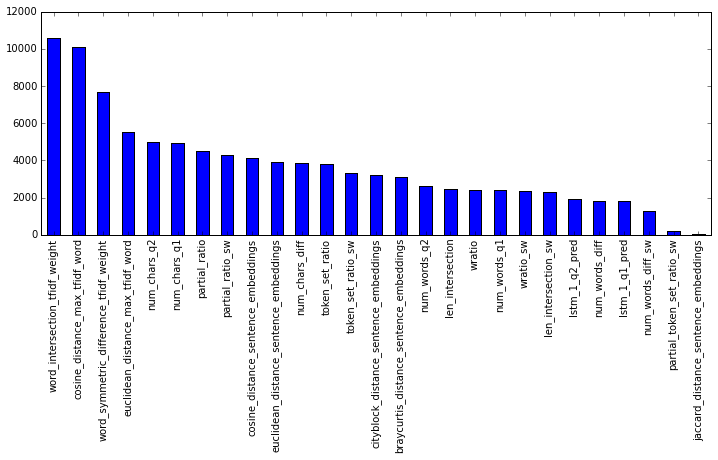

In [102]:
feature_importance(grid_result1.best_estimator_)

#### LSTM Model 2

In [106]:
model2 = XGBClassifier(random_state = 550)

In [107]:
grid_search2 = GridSearchCV(model1, xgb_params, scoring='neg_log_loss', n_jobs=-1, cv=3, verbose=1)

In [108]:
%time grid_result2 = grid_search1.fit(X_train[original_features + ['lstm_2_q1_pred', 'lstm_2_q2_pred']], \
                                      y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed: 24.3min finished


CPU times: user 19min 58s, sys: 3.3 s, total: 20min 1s
Wall time: 50min 32s


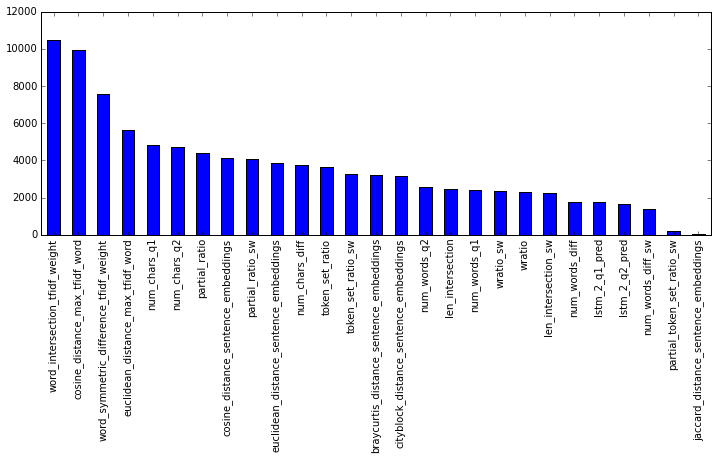

In [116]:
feature_importance(grid_result2.best_estimator_)

In [117]:
grid_result2.best_score_

-0.42515725363303974

#####  LSTM Model 3

In [133]:
model3 = XGBClassifier(random_state = 550)

In [134]:
grid_search3 = GridSearchCV(model3, xgb_params, scoring='neg_log_loss', n_jobs=2, cv=3, verbose=1)

In [140]:
%time grid_result3 = grid_search3.fit(X_train[original_features + ['lstm_3_q1_pred', 'lstm_3_q2_pred']], \
                                      y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=2)]: Done   3 out of   3 | elapsed: 31.2min finished


CPU times: user 22min 31s, sys: 20.7 s, total: 22min 51s
Wall time: 55min


In [141]:
grid_result3.best_score_

-0.42471647170023635

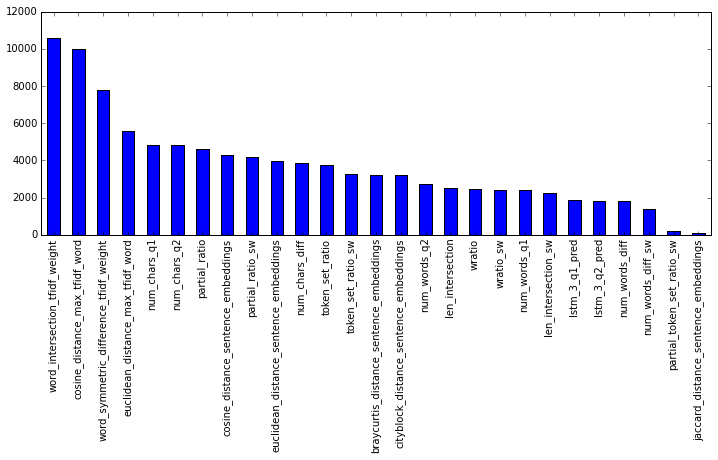

In [142]:
feature_importance(grid_result3.best_estimator_)

##### LSTM Model 4

In [148]:
model4 = XGBClassifier(random_state = 550)

In [149]:
grid_search4 = GridSearchCV(model4, xgb_params, scoring='neg_log_loss', n_jobs=-1, cv=3, verbose=1)

In [152]:
%time grid_result4 = grid_search4.fit(X_train[original_features + ['lstm_4_q1_pred', 'lstm_4_q2_pred']], \
                                      y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed: 29.6min finished


CPU times: user 22min 7s, sys: 8.41 s, total: 22min 15s
Wall time: 52min 25s


In [153]:
grid_result4.best_score_

-0.42471371311147393

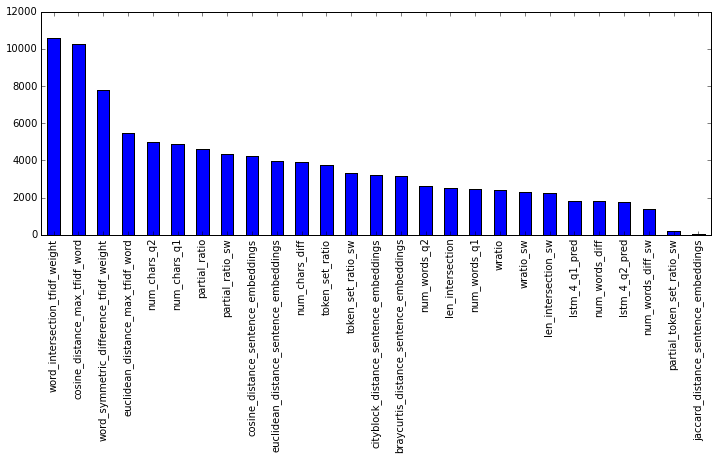

In [154]:
feature_importance(grid_result4.best_estimator_)

##### LSTM Model 5

In [165]:
model5 = XGBClassifier(random_state = 550)

In [166]:
grid_search5 = GridSearchCV(model5, xgb_params, scoring='neg_log_loss', n_jobs=-1, cv=3, verbose=1)

In [167]:
%time grid_result5 = grid_search5.fit(X_train[original_features + ['lstm_5_q1_pred', 'lstm_5_q2_pred']], \
                                      y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed: 62.1min finished


CPU times: user 21min 39s, sys: 8.39 s, total: 21min 47s
Wall time: 1h 45min 28s


In [168]:
grid_result5.best_score_

-0.42554912014690094

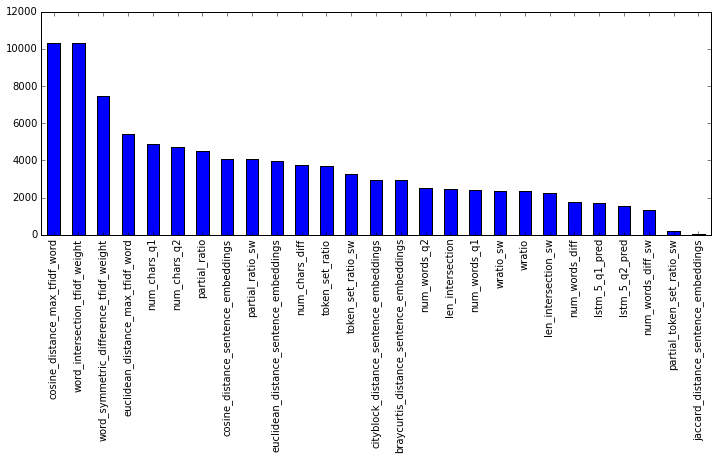

In [169]:
feature_importance(grid_result5.best_estimator_)